<h1 style="font-size: 50px">Real-World Graphs</h1>

# imports, settings and needed functions

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances
from graph import Graph
from helpers import get_hermitian_adjacency_matrix, get_adjacency_matrix, get_degree_matrix, get_laplacian_matrix

In [2]:
np.random.seed(9)
font = {'size'   : 16}

plt.rc('font', **font)

General Functions

In [3]:
def knn_adjacency_matrix(features, k, metric='euclidean'):
    if k <= 0:
        raise ValueError("k must be a positive integer.")

    # Compute the pairwise distances
    distances = pairwise_distances(features, metric=metric)

    # Get the indices of the k-nearest neighbors for each point
    knn_indices = np.argsort(distances, axis=1)[:, 1:k+1]

    # Initialize the adjacency matrix
    n_points = features.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=float)

    # Fill the adjacency matrix
    for i in range(n_points):
        for j in knn_indices[i]:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Ensure the graph is undirected

    return adjacency_matrix
def get_thresholded_correlation_matrix(features, threshold):
    correlation_matrix = np.corrcoef(features)

    # Create a graph using the correlation matrix
    correlation_matrix[correlation_matrix < threshold] = 0
    return correlation_matrix
                

def get_normalised_laplacian(A):
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag([1/np.sqrt(d) for d in degrees])
    return np.eye(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt


def k_means_indicator_vectors(eigenvectors, K):
    assert eigenvectors.shape[1] >= K, 'Number of eigenvectors should be greater than or equal to K'
    kmeans = KMeans(n_clusters=K, random_state=0).fit(eigenvectors)
    indicator_vectors = np.zeros((eigenvectors.shape[0], K))
    for i in range(K):
        indicator_vectors[:,i] = kmeans.labels_ == i
    return indicator_vectors

def degree_correction(vectors, D_sqrt):
    vectors_corrected = vectors.copy()
    for i in range(vectors.shape[1]):
        vectors_corrected[:,i] = D_sqrt @ vectors[:,i]
        vectors_corrected[:,i] = vectors_corrected[:,i] / np.linalg.norm(vectors_corrected[:,i])
    return vectors_corrected

def compute_rayleigh_quotients(normalised_L, indicator_vectors, K):
    rayleigh_quotients = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = (indicator.T @ normalised_L @ indicator) / (indicator.T @ indicator)
        rayleigh_quotients.append(val)
    return rayleigh_quotients


def dfs(node, adj_matrix, visited, component):
    """
    Depth-first search to collect all nodes in the same connected component.

    Parameters:
        node (int): The current node being visited.
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.
        visited (set): A set of visited nodes.
        component (list): List to store nodes in the current component.
    """
    visited.add(node)
    component.append(node)
    for neighbor, is_connected in enumerate(adj_matrix[node]):
        if is_connected and neighbor not in visited:
            dfs(neighbor, adj_matrix, visited, component)

def largest_connected_component(adj_matrix):
    """
    Finds the largest connected component of a graph from its adjacency matrix.

    Parameters:
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.

    Returns:
        numpy.ndarray: The adjacency matrix of the largest connected component.
        list: indices of nodes in largest component.
    """
    n = len(adj_matrix)
    visited = set()
    components = []

    # Find all connected components
    for node in range(n):
        if node not in visited:
            component = []
            dfs(node, adj_matrix, visited, component)
            components.append(component)

    # Identify the largest connected component
    largest_cc = max(components, key=len)

    # Create the adjacency matrix for the largest connected component
    size = len(largest_cc)
    largest_cc_matrix = np.zeros((size, size), dtype=int)

    node_index = {node: i for i, node in enumerate(largest_cc)}
    for i in largest_cc:
        for j in largest_cc:
            if adj_matrix[i][j]:
                largest_cc_matrix[node_index[i]][node_index[j]] = 1

    return largest_cc_matrix, largest_cc


Simple search algorithm for finding a good split of eigenvalues to apply the recursive structure theorem

In [4]:
def apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error):
    R = rayleigh_quotients[start:end]
    l = end-start
    val = np.sum(R) - l * eigenvalues[start] + eigenvalues[end] * error
    if (eigenvalues[end] != eigenvalues[start]) and (eigenvalues[end] != 0):
        val = val / (eigenvalues[end] - eigenvalues[start])
        print(val)
        return val
    else:
        return 0
    
def apply_recursive_st_search(rayleigh_quotients, eigenvalues, start, error, bound_indices, values):
    # we begin initial search for first error bound
    indices = list(range(len(rayleigh_quotients)))
    if bound_indices and max(bound_indices) == len(rayleigh_quotients)-1:
        return bound_indices, values
    else:
        vals_temp = []
        indices_to_search = indices[start+1:]
        for end in indices_to_search:
            vals_temp.append(apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error = error))
        min_val = min(vals_temp)
        min_index = vals_temp.index(min_val)
        bound_indices.append(indices_to_search[min_index])
        values.append(min_val)
        print(f"Difference between {start} and {bound_indices[-1]}")
        return apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=bound_indices[-1], error = np.sum(values), bound_indices=bound_indices, values = values)
    

EDITED VERSION BELOW

In [5]:
def apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error):
    R = rayleigh_quotients[start:end]
    l = end-start
    val = np.sum(R) - l * eigenvalues[start] + eigenvalues[end] * error
    if (eigenvalues[end] != eigenvalues[start]) and (eigenvalues[end] != 0):
        val = val / (eigenvalues[end] - eigenvalues[start])
        print(val)
        return val
    else:
        return 0
    
def apply_recursive_st_search(rayleigh_quotients, eigenvalues, start, error, bound_indices, values):
    # we begin initial search for first error bound
    indices = list(range(len(eigenvalues)))
    if bound_indices and max(bound_indices) == len(eigenvalues)-1:
        return bound_indices, values
    else:
        vals_temp = []
        indices_to_search = indices[start+1:]
        for end in indices_to_search:
            vals_temp.append(apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error = error))
        min_val = min(vals_temp)
        min_index = vals_temp.index(min_val)
        bound_indices.append(indices_to_search[min_index])
        values.append(min_val)
        print(f"Difference between {start} and {bound_indices[-1]}")
        print("Rayleigh quotient indices accounted for: ")
        return apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=bound_indices[-1], error = np.sum(values), bound_indices=bound_indices, values = values)


ATTEMPT TO IMPROVE RECURSIVE ST SEARCH

In [6]:
def apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error):
    R = rayleigh_quotients[start:end]
    l = end-start
    val = np.sum(R) - l * eigenvalues[start] + eigenvalues[end] * error
    if (eigenvalues[end] != eigenvalues[start]) and (eigenvalues[end] != 0):
        val = val / (eigenvalues[end] - eigenvalues[start])
        print(val)
        return val
    else:
        return 0
    
def apply_recursive_st_search_2step(rayleigh_quotients, eigenvalues, start, error, bound_indices, values):
    # we begin initial search for first error bound
    indices = list(range(len(eigenvalues)))
    if bound_indices and max(bound_indices) == len(eigenvalues)-1:
        return bound_indices, values
    else:
        vals_temp_second_step = []
        vals_temp = []
        indices_to_search = indices[start+1:]
        for end in indices_to_search:
            val = apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error = error)
            _, v = apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=end, error = np.sum(values) + val, bound_indices=bound_indices, values = values)
            vals_temp_second_step.append(np.sum(v) + val)
            vals_temp.append(val)
        min_val_second_step = min(vals_temp_second_step)
        min_index = vals_temp_second_step.index(min_val_second_step)
        min_val = vals_temp[min_index]
        bound_indices.append(indices_to_search[min_index])
        values.append(min_val)
        print(f"Difference between {start} and {bound_indices[-1]}")
        print("Rayleigh quotient indices accounted for: ")
        return apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=bound_indices[-1], error = np.sum(values), bound_indices=bound_indices, values = values)


In [7]:
dataset_results = {}

# MNIST Dataset

In [8]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2, 3, 4]
samples_per_digit = 500
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
# compute first K eigenvectors of the normalized Laplacian
K=5
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


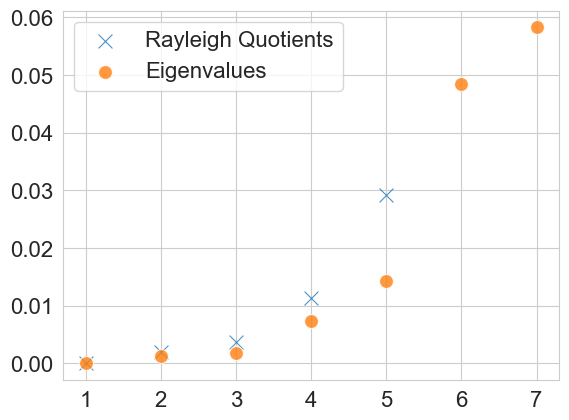

In [11]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x = [1,2,3,4,5],y = rayleigh_quotients, alpha = 0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x = [1,2,3,4,5,6,7], y = normalized_L_eigenvalues[0:7], alpha = 0.8, marker = 'o',s=100, label='Eigenvalues')
plt.legend()

In [12]:
true_val_matrix_combined = normalized_L_eigenvectors[:,:5] - indicator_vectors @ (indicator_vectors.T @ normalized_L_eigenvectors[:,:5])
true_val_combined = (1/5) * np.linalg.norm(true_val_matrix_combined)**2

In [13]:
b, v = apply_recursive_st_search(rayleigh_quotients[0:5], normalized_L_eigenvalues[0:5], 0, error = 0, bound_indices = [], values = [])

2.444923357268638e-13
1.169092046284238
0.7834362335279933
1.191271970764126
Difference between 0 and 1
Rayleigh quotient indices accounted for: 
1.7101481460458732
0.5148889442553168
1.0079757458064487
Difference between 1 and 3
Rayleigh quotient indices accounted for: 
1.6260980268371068
Difference between 3 and 4
Rayleigh quotient indices accounted for: 


In [14]:
np.sum(v)/5

0.42819739421853364

In [18]:
b, v = apply_recursive_st_search_2step(rayleigh_quotients[0:5], normalized_L_eigenvalues[0:5], 0, error = 0, bound_indices = [], values = [])

2.444923357268638e-13
1.7101481460458732
0.5148889442553168
1.0079757458064487
Difference between 1 and 3
Rayleigh quotient indices accounted for: 
1.626098026836609
Difference between 3 and 4
Rayleigh quotient indices accounted for: 
1.169092046284238
0.7834362335279933
1.191271970764126
Difference between 0 and 1
Rayleigh quotient indices accounted for: 


In [19]:
np.sum(v)/5

0.4281973942184341

In [20]:
mnist_dataset_results = {}
print("K: ", K)
mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/5)
mnist_dataset_results["Recursive ST"] = np.sum(v)/5

dataset_results["MNIST"] = mnist_dataset_results

K:  5
Number of vertices N:  2348
Number of edges M:  140018
True value:  0.01277183842880367
M&S ST:  0.43945091443546835
General ST:  0.1914964218584773
Recursive ST:  0.4281973942184341


# Fashion MNIST

In [21]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 1000
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [22]:
# compute first K eigenvectors of the normalized Laplacian
K=3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


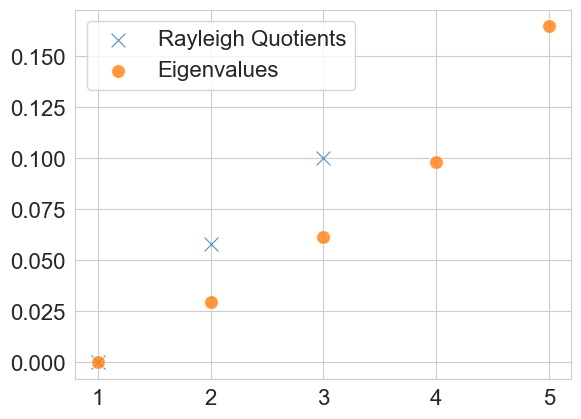

In [23]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5], y=normalized_L_eigenvalues[0:5], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [24]:
b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
np.sum(v)/3

1.7102204913152657e-14
0.9439147809984682
1.6060111754113842
Difference between 0 and 1
Rayleigh quotient indices accounted for: 
0.892302020502785
1.4375445436022487
Difference between 1 and 2
Rayleigh quotient indices accounted for: 
3.4222890474929346
Difference between 2 and 3
Rayleigh quotient indices accounted for: 


1.4381970226652456

In [25]:
b2, v2 = apply_recursive_st_search_2step(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])

1.7102204913152657e-14
0.892302020502785
1.4375445436022487
Difference between 1 and 2
Rayleigh quotient indices accounted for: 
3.4222890474928893
Difference between 2 and 3
Rayleigh quotient indices accounted for: 
0.9439147809984682
1.6060111754113842
Difference between 0 and 1
Rayleigh quotient indices accounted for: 


In [26]:
np.sum(v2)/3

1.4381970226652303

In [27]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2

fashion_mnist_dataset_results = {}
print("K: ", K)
fashion_mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
fashion_mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
fashion_mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
fashion_mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
fashion_mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
fashion_mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/3)
fashion_mnist_dataset_results["Recursive ST"] = np.sum(v)/3

dataset_results["Fashion MNIST"] = fashion_mnist_dataset_results

K:  3
Number of vertices N:  2875
Number of edges M:  1711217
True value:  0.04341537349979763
M&S ST:  1.0160649241306232
General ST:  0.5353370584704586
Recursive ST:  1.4381970226652456


# IRIS

In [28]:
iris = fetch_openml('iris', version=1, as_frame=False)
x_data, y_data = iris.data, iris.target

targets = np.unique(y_data).tolist()

selected_samples = []
selected_labels = []

for target in targets:
    indices = np.where(y_data == target)[0]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

selected_samples = np.vstack(selected_samples)
selected_labels = np.array(selected_labels)
# Calculate the Pearson correlation matrix
adjacency_matrix = knn_adjacency_matrix(x_data,5)
normalized_laplacian = get_normalised_laplacian(adjacency_matrix)


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [29]:
# compute first K eigenvectors of the normalized Laplacian
K=3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

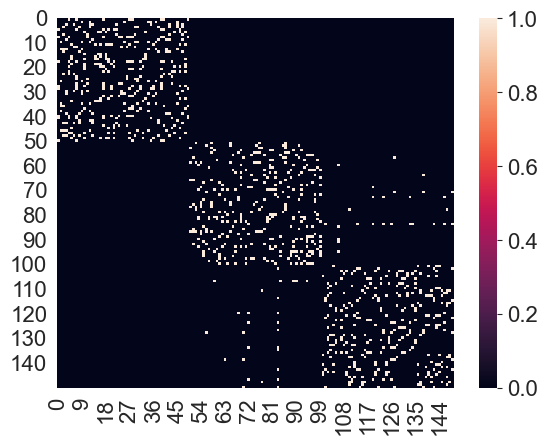

In [30]:
sns.heatmap(adjacency_matrix)

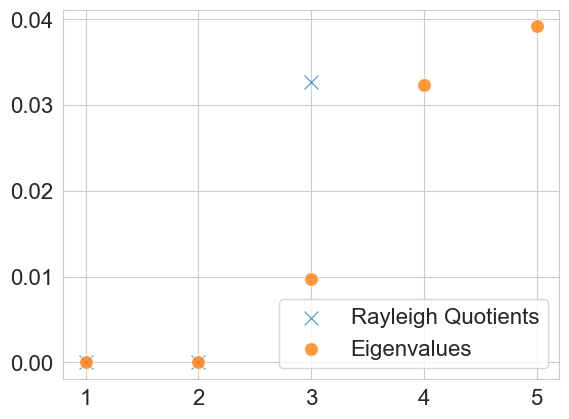

In [31]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5], y=normalized_L_eigenvalues[0:5], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [32]:
rayleigh_quotients = np.round(rayleigh_quotients,6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues,6)
b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])

0.0
1.0081185368112362
Difference between 0 and 1
Rayleigh quotient indices accounted for: 
0.0
1.0081185368112362
Difference between 1 and 2
Rayleigh quotient indices accounted for: 
1.0116114790286976
Difference between 2 and 3
Rayleigh quotient indices accounted for: 


In [33]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2
print("N: ", len(adjacency_matrix))
print("K: ", K)
print("True value: ", true_val_combined)
print("M&S ST: ",
      max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors)) / normalized_L_eigenvalues[K])
#print("General ST: ", max(rayleigh_quotients)/normalized_L_eigenvalues[K])

B_1 = rayleigh_quotients[0] / normalized_L_eigenvalues[1] if rayleigh_quotients[0] > 0 else 0
B_2 = ((rayleigh_quotients[1] - normalized_L_eigenvalues[1]) + normalized_L_eigenvalues[2] * B_1) / (
            normalized_L_eigenvalues[2] - normalized_L_eigenvalues[1]) if rayleigh_quotients[1] > 0 else 0
B_3 = ((rayleigh_quotients[2] - normalized_L_eigenvalues[2]) + normalized_L_eigenvalues[3] * (B_1 + B_2)) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
print("Recursive ST: ", (B_1 + B_2 + B_3) / 3)

iris_dataset_results = {}
print("K: ", K)
iris_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
iris_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
iris_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
iris_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
iris_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
iris_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/K)
iris_dataset_results["Recursive ST"] = np.sum(v)/K

dataset_results["IRIS"] = iris_dataset_results

N:  150
K:  3
True value:  0.05993164395890421
M&S ST:  0.6457941686078185
Recursive ST:  0.3372038263428992
K:  3
Number of vertices N:  150
Number of edges M:  1027.0
True value:  0.05993164395890421
M&S ST:  0.6457941686078185
General ST:  0.3360395122704121
Recursive ST:  0.3372038263428992


| Dataset         | N   | K | True Value | M&S ST  | Recursive ST |
|-----------------|-----|---|------------|---------|--------------|
| MNIST           | 530 | 3 | 0.0152     | 0.4705  | 0.1653       |
| Fashion MNIST   | 560 | 3 | 0.0306     | 0.2987  | 0.1696       |
| IRIS            | 150 | 3 | 0.0599     | 0.6458  | 0.3377       |



# Wine Dataset

In [34]:
wine_df = pd.read_csv("Data/Wine dataset.csv")

In [35]:
wine_df_targets = wine_df['class']
wine_df_features = wine_df.drop(columns = ['class'])
wine_df_features_normalized = (wine_df_features - wine_df_features.mean())/wine_df_features.std()
wine_df_features_normalized.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


In [36]:
wine_df_features_cov = np.cov(wine_df_features_normalized)
wine_df_features_cov

array([[ 0.93665081,  0.70184685,  0.3630285 , ..., -0.32185096,
        -0.2505038 , -0.76827041],
       [ 0.70184685,  0.93622896,  0.28952793, ..., -0.44112901,
        -0.45162726, -0.87082049],
       [ 0.3630285 ,  0.28952793,  0.54812415, ..., -0.40194741,
        -0.34428338, -0.50324177],
       ...,
       [-0.32185096, -0.44112901, -0.40194741, ...,  1.5529139 ,
         1.25238444,  1.16647352],
       [-0.2505038 , -0.45162726, -0.34428338, ...,  1.25238444,
         1.22720324,  1.03076966],
       [-0.76827041, -0.87082049, -0.50324177, ...,  1.16647352,
         1.03076966,  1.67590286]])

In [37]:
wine_df_features_cov_thresholded = wine_df_features_cov.copy()
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded < 0.3] = 0
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded >= 0.3] = 1 
adjacency_matrix = wine_df_features_cov_thresholded.copy()

normalized_laplacian = get_normalised_laplacian(adjacency_matrix)

# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


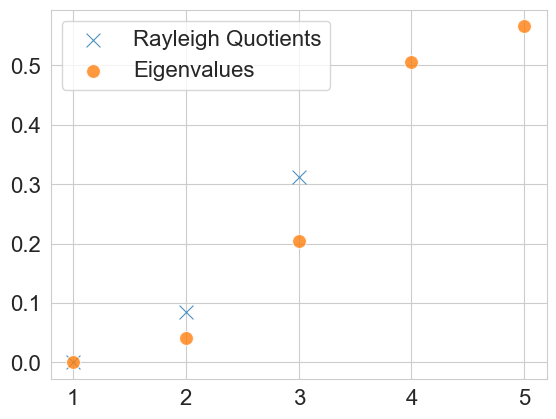

In [38]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5], y=normalized_L_eigenvalues[0:5], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [39]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
        indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues, 6)

b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])

wine_dataset_results = {}
print("K: ", K)
wine_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
wine_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
wine_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
wine_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
wine_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
wine_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/3)
wine_dataset_results["Recursive ST"] = np.sum(v)/3

dataset_results["Wine"] = wine_dataset_results

0.0
0.4153526625421877
0.7826025116008938
Difference between 0 and 1
Rayleigh quotient indices accounted for: 
0.26389214392322774
0.6724428378780111
Difference between 1 and 2
Rayleigh quotient indices accounted for: 
0.7972055791736885
Difference between 2 and 3
Rayleigh quotient indices accounted for: 
K:  3
Number of vertices N:  178
Number of edges M:  6890.0
True value:  0.06456321090483377
M&S ST:  0.4498140716518029
General ST:  0.2608675038669646
Recursive ST:  0.35369924103230543


In [40]:
pd.DataFrame(dataset_results).T

,K,N,M,True Value,M&S ST,General ST,Recursive ST
MNIST,5.0,2348.0,140018.0,0.012772,0.439451,0.191496,0.428197
Fashion MNIST,3.0,2875.0,1711217.0,0.043415,1.016065,0.535337,1.438197
IRIS,3.0,150.0,1027.0,0.059932,0.645794,0.336040,0.337204
Wine,3.0,178.0,6890.0,0.064563,0.449814,0.260868,0.353699


In [47]:
np.round(pd.DataFrame(dataset_results).T,4)

,K,N,M,True Value,M&S ST,General ST,Recursive ST
MNIST,5.0,2348.0,140018.0,0.0128,0.4395,0.1915,0.4282
Fashion MNIST,3.0,2875.0,1711217.0,0.0434,1.0161,0.5353,1.4382
IRIS,3.0,150.0,1027.0,0.0599,0.6458,0.3360,0.3372
Wine,3.0,178.0,6890.0,0.0646,0.4498,0.2609,0.3537
